# Enunciado: Una noche en el casino
En un casino un jugador dispone de 30 fichas y decide jugar una noche a la ruleta.

La ruleta estándar contiene 37 ranuras, numeradas del 0 al 36. Entre los números del 1 al 10 y del 19 al 28, los números pares van en rojo y los impares en negro. Entre los números del 11 al 18 y del 29 al 36, los números pares van en negro y los impares en rojo. El 0 es verde.

Las probabilidades de pago vienen determinadas por la posibilidad de que la bola en aterrice en la ranura seleccionada. Sin embargo, las probabilidades solamente tienen en cuenta las 36 ranuras negras y rojas numeradas y no la ranura verde del
0.Por ejemplo, si apuestas a un solo número tienes una posibilidad entre 37 (1/37) de acertar, y 36 posibilidades de 37 (36/37) de no acertar. Sin embargo, la cuota paga a 35:1, no a 36:1. La ranura del 0 es lo que se denomina “margen de la casa” (house edge), es decir el dinero que el casino espera recibir.

El jugador puede realizar las siguientes apuestas, con los premios correspondientes:
* Pagos 1:1. Los pagos 1:1 son apuestas que te ofrecen una devolución de dinero igualada. Por ejemplo, si apuestas una ficha y aciertas ganas 1 ficha más la ficha apostada. Los tres pagos más comunes 1:1 son los de a favor del rojo, del negro, de par/impar o a favor de un número alto o bajo (1-18 o 19-36).
* Pagos 2:1. Apostar a una serie de doce números (docena). Véanse en el tablero los tres espacios de apuesta para las seis docenas por las que se puede apostar (por filas y por columnas).
* Pagos 5:1. Apostar en series de seis números, colocando las fichas en el lateral de la mesa entre dos filas, significa que estas apostando a los tres números de ambas filas.
* Pagos 8:1. Apostar en una serie de cuatro números, colocando las fichas en el medio de cuatro números.
* Pagos 11:1. Apostar en una fila de tres números, colocando las fichas en el lateral de la tabla junto a una fila.
* Pagos 17:1. Apostar a un par de números, vertical u horizontal, colocando la ficha entre los dos números elegidos.
*  Pagos 35:1. Para ganar un pago 35:1, tendrás que apostar a un solo número.

El jugador siempre va a apostar una ficha y se retira cuando se queda sin fichas o cuando alcanza las 150.

Se estima que el número máximo de partidas que se pueden jugar en una noche es de 50.

Partiendo del planteamiento del problema anterior se deberán resolver las siguientes cuestiones: 
1. Si decide apostar al azar (de forma equiprobable en entre los distintos tipos de apuestas):
    
    a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?
    
    b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?
    
    c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?
    
    
2.  Si analizamos el problema a largo plazo, jugando partidas indefinidamente, y empezando con 30 fichas ¿cuál es la probabilidad de que me quede sin dinero? ¿y la de que termine con 150 fichas?


3.  ¿Con qué probabilidad debería jugar a cada una de las partidas para que el beneficio medio de cada noche sea máximo? Utilícese la metaheurística recocido simulado.


## 0.  Pasos previos

### Cargar librerías y funciones necesarias

In [1]:
import transition_matrix as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from random import randrange
import numpy.random as rnd
from numpy.linalg import matrix_power
print("Se han cargado todas las librerias necesarias")

Se han cargado todas las librerias necesarias


In [2]:
gambling_random = np.random
gambling_random.seed(42)

In [3]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### Modelización del enunciado
En esta sección vamos a modelar los diferentes elementos que componen nuestro problema. 
* Juego de la ruleta: probabilidades de ganar cierta apuesta de la ruleta y beneficio obtenido

In [4]:
bets = [(1, float(18 / 37)), # Pagos 1:1.
        (2, float(12 / 37)), # Pagos 2:1.
        (5, float(6 / 37)),  # Pagos 5:1.
        (8, float(4 / 37)),  # Pagos 8:1
        (11, float(3 / 37)), # Pagos 11:1.
        (17, float(2 / 37)), # Pagos 17:1.
        (35, float(1 / 37))] # Pagos 35:1.

* Probabilidades de realizar las apuestar anteriormente realizadas, son probabilidades equiprobables. A continuación el algoritmio SA se encargará de buscar el vector de probabilidades óptimo. 

In [5]:
p_bets_eq = [float(1/len(bets))]*len(bets)
p_bets_eq

[0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

* Límite de partidas y fichas: 

In [6]:
LEAVE_WITH_MIN = 0 # Mínimo número de fichas con las que el jugador se retira
LEAVE_WITH_MAX = 150 # Máximo número de fichas con las que el jugador se retira
NUM_GAMES = 50 # Número máximo de partidas que puede jugar un jugador
INITIAL_CHIPS = 30 # Número de fichas iniciales con las que comienza a jugar
DAYS = 30 # Número de días que el jugador va a ir a jugara a la ruleta

### Construir la matriz de transición

Una cadena es un proceso en tiempo discreto en el que una variable aleatoria $X_n$ va cambiando con el paso del tiempo. Las
cadenas de Markov tienen la propiedad de que la probabilidad de que $X_n = j$ sólo depende
del estado inmediatamente anterior del sistema: $X_n−1$. Cuando en una cadena dichas
probabilidades no dependen del tiempo en que se considere, $n$, $P(X_n = j | X-{n−1} = i)$

A continuación vamos a construir la cadena de Markov haciendo uso de la función `create_transition_matrix` que nosotros mismos hemos implementado. Esta mátriz se construye básandonos en el enunicado anteriormente comentado y en las propiedades de la cadena de Markov: 
$$
T = [p_{ij}] = \begin{bmatrix}
p_{1,1} & p_{1,2}  & \cdots  & p_{1,m} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{2,m}\\ 
\vdots & \vdots & \ddots &  \cdots \\ 
p_{m,1} & p_{m,2}  & \cdots  &  p_{m,m}
\end{bmatrix}
$$

donde $p_{ij}$ es la probabilidad de ir del estado $i$ al $j$. En nuestro caso, un estado representa la cantidad de fichas que nuestro jugador tiene en ese momento. La probabilidad $p_{ij}$ es la probabilidad con la que el jugador pasa de tener $i$ a $j$ fichas. Cada una de las probabilidades se calcula de la siguiente manera: 

$P(probabilidad \  de\  realizar\  esta \ apuesta | probabilidad \ de\  ganar\  la\  apuesta)$

La matriz de transición se construye sabiendo los estados (en este caso el valor máximo y mínimo de fichas que puede alcanzar el jugador), las probabilidades de realizar las apuestas y las probabilidades de ganar la apuesta realizada. 

In [7]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq)

Vamos a visualizar la matriz creada por medio de la libreria pandas y añadiendo un vector de filas y columnas que representan los estados del problema, es decir, las fichas que tiene el jugador en cada momento. 

In [8]:
df = pd.DataFrame(matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.000000,0.000000,0.0,0.0,0.007722,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003861,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.000000,0.0,0.0,0.000000,0.007722,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003861,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.0,0.0,0.000000,0.000000,0.007722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003861,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Funciones para la simulación
En esta sección se definen las funciones necesarias para llevar a cabo la simulación. 
Para llevar a cabo esta simulación se han implementado tres funciones:
* `simulate_game`: esta función recibe como parámetro el estado en el que se encuentra el jugador, es decir, el número de fichas actuales. El jugador entonces realiza una apuesta y se produce la tirada de la ruleta. En función del resultado el jugador recibe un número de fichas o pierda la que ha apostado. Esta transición de pasar de un número de fichas a otro número de fichas se realiza mediante la matriz de transición anteriormente implementada. 
* `simulate_night`: esta función simula todas las posibles partidas que se puedan realizar en una noche en el casino. Básicamente ejecuta el metodo `simulate_game` tantas veces como número máximo de veces pueda jugar el jugador. Además en este método se recopila información a cerca de la evolución del número de fichas a lo largo de la noche. 
* `simulate_num_days`: esta función simula todas los días en los que el jugador va al casino. 

In [9]:
def simulate_game(state, matrix, gambling_random):
    return gambling_random.choice(range(len(matrix[state])), p=matrix[state])

In [10]:
def simulate_night(matrix, gambling_random, NUM_GAMES, state):
    chips = []
    games = 0
    chips.append(state)
    for i in range(NUM_GAMES):
        chips.append(simulate_game(chips[-1], matrix, gambling_random))
        if chips[-2] != LEAVE_WITH_MIN: games +=1
    return chips, games
        

In [11]:
def simulate_num_days(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS):
    return [simulate_night(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS) for i in range(DAYS)]

In [12]:
def simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS):
    simulation = simulate_num_days(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
    chips = [simulation[i][0] for i in range(DAYS)]
    games = [simulation[i][1] for i in range(DAYS)]
    return simulation, chips, games

### Funciones auxiliares
En esta sección se encuentran las funciones auxiliares para desarrollar diferentes tareas: representación, manejo de datos, manejo de estructuras, visualización...

In [13]:
def plot_chips_evolution(chips):
    x = range(len(chips[0]))
    plt.figure(figsize=(15, 15))
    for i,y in enumerate(chips):
        plt.plot(x, y,linewidth=4.0,  marker='o')
    plt.axhline(y=INITIAL_CHIPS, color='black', linestyle='-')

In [14]:
def create_df(chips, games):
    final_chips = [x[-1] for x in chips]
    improvement = [((x/INITIAL_CHIPS)-1) for x in final_chips]
    benefit = [(x-INITIAL_CHIPS) for x in final_chips]
    days = list(range(1, DAYS+1))
    d = {'Day':days, 'Chips': final_chips, 'Games': games, 'Benefit': benefit, 'Improvement': improvement} 
    df = pd.DataFrame(d)
    return df

In [15]:
def plot_bar_graph(df, INITIAL_CHIPS):
    x = df['Day']
    y = df['Chips']
    mask1 = df['Chips'] < INITIAL_CHIPS
    mask2 = df['Chips'] >= INITIAL_CHIPS
    plt.figure(figsize=(20,10))
    plt.bar(x[mask1], y[mask1], color = 'red')
    plt.bar(x[mask2], y[mask2], color = 'blue')
    plt.axhline(y=INITIAL_CHIPS, color='black', linestyle='-')
    plt.xlabel("Días")
    plt.ylabel("Número de fichas")
    plt.show()

In [16]:
def plot_results(valores_y, valores_t, x):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Resultados de la optimización')
    ax1.set_title('Evolución de la temperatura')
    ax2.set_title('Calidad (Valores de y)')
    ax1.plot(valores_t, 'tab:orange')
    ax2.plot(valores_y, 'tab:red')
    print("Vector de probabilidades: " + str(x))
    print("Fichas obtenidas: " + str(valores_y[-1]))

In [18]:
def show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX):
    print("Número de noches que el jugador perdió todas las fichas: " + str(np.count_nonzero(df['Chips']==0)))
    print("Porcentaje de noches que el jugador perdió todas las fichas: " + str(round((np.count_nonzero(df['Chips']==0)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador perdió fichas: " + str(np.count_nonzero(df['Chips']<INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador perdió fichas: " + str(round((np.count_nonzero(df['Chips']<INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador salió igual del casino: " + str(np.count_nonzero(df['Chips']==INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador salió igual del casino: " + str(round((np.count_nonzero(df['Chips']==INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador ganó fichas: " + str(np.count_nonzero(df['Chips']>INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador ganó fichas: " + str(round((np.count_nonzero(df['Chips']>INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador se retiró alcanzando el máximo de fichas: " + str(np.count_nonzero(df['Chips']>=LEAVE_WITH_MAX)))
    print("Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: " + str(round((np.count_nonzero(df['Chips']>=LEAVE_WITH_MAX)/DAYS)*100,2)) + "%")

## Ejercicio 1: Si decide apostar al azar:
###       a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?

Lo primero que vamos a hacer es ejecutar la simulación. Recordamos los parámetros, la probabilidad de realizar cada una de las posibles apuestas es equiprobable, el número máximo de partidas que se puede jugar una noche es 50, el jugador va a ir todos los días de un mes, es decir, 30 días, si el jugador alcanza 0 fichas o 150 o más se planta. Además, el jugador empieza cada noche con 30 fichas. 

In [18]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 50
INITIAL_CHIPS = 30
DAYS = 30

In [19]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

La simulación se ha realizado, veaos cual es el resultado obtenido a lo largo del mes: 

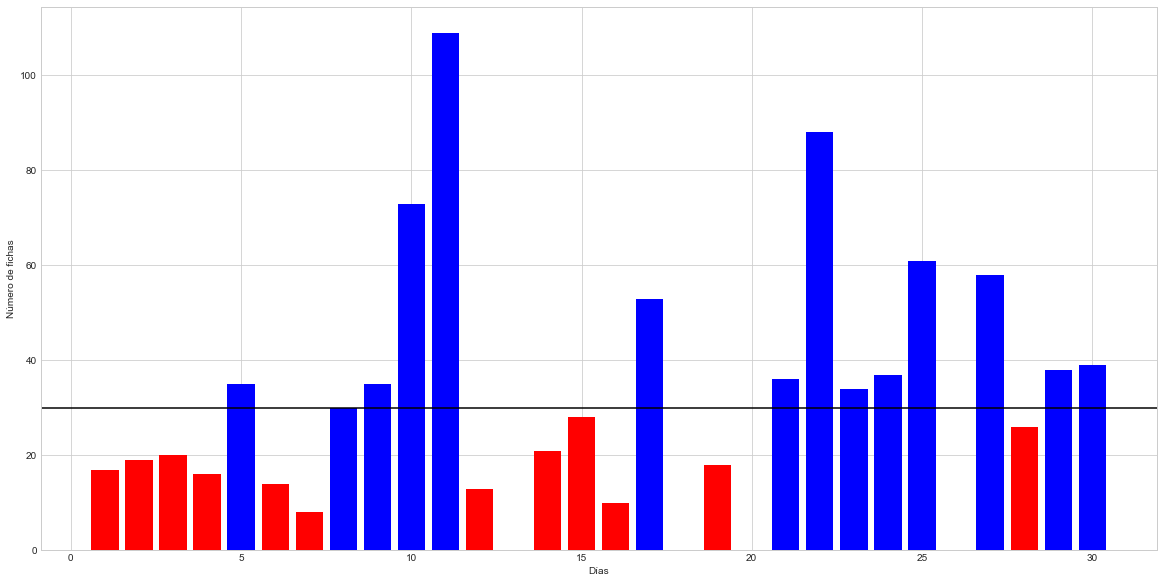

In [20]:
plot_bar_graph(df, INITIAL_CHIPS)

En el gráfico anterior se muestran en el eje x los diferentes días del mes. En el eje y se muestra el número de fichas con las que el jugador salio del casino cada uno de los días. La línea negra muestra el número de fichas con el que el jugador entró al casino. Las barras coloreadas de color rojo son los días malos de nuestro jugador en los cuales perdió fichas. Por otro lado, los días con barras azules son días en los que el jugador obtuvo beneficio. Si un día no muestra barra es por que el jugador se fue ese día sin ninguna ficha. 

Respondiendo a la pregunta, el número de noches en las que el jugador se ha tenido que retirar por que se ha quedado sin dinero es el siguiente: 

In [21]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 4
Porcentaje de noches que el jugador perdió todas las fichas: 13.33%
Número de noches que el jugador perdió fichas: 16
Porcentaje de noches que el jugador perdió fichas: 53.33%
Número de noches que el jugador salió igual del casino: 1
Porcentaje de noches que el jugador salió igual del casino: 3.33%
Número de noches que el jugador ganó fichas: 13
Porcentaje de noches que el jugador ganó fichas: 43.33%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 0
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 0.0%


###        b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?

En el gráfico anterior se mostró cuales eran las fichas que nuestro jugador había sido capaz de llevarse a casa para cada uno de los días del mes. 
Vamos a aprovechar esta pregunta para visualizar la evolución de la cantidad de fichas que tuvo nuestro jugador a lo largo de cada uno de los días en el casino. 

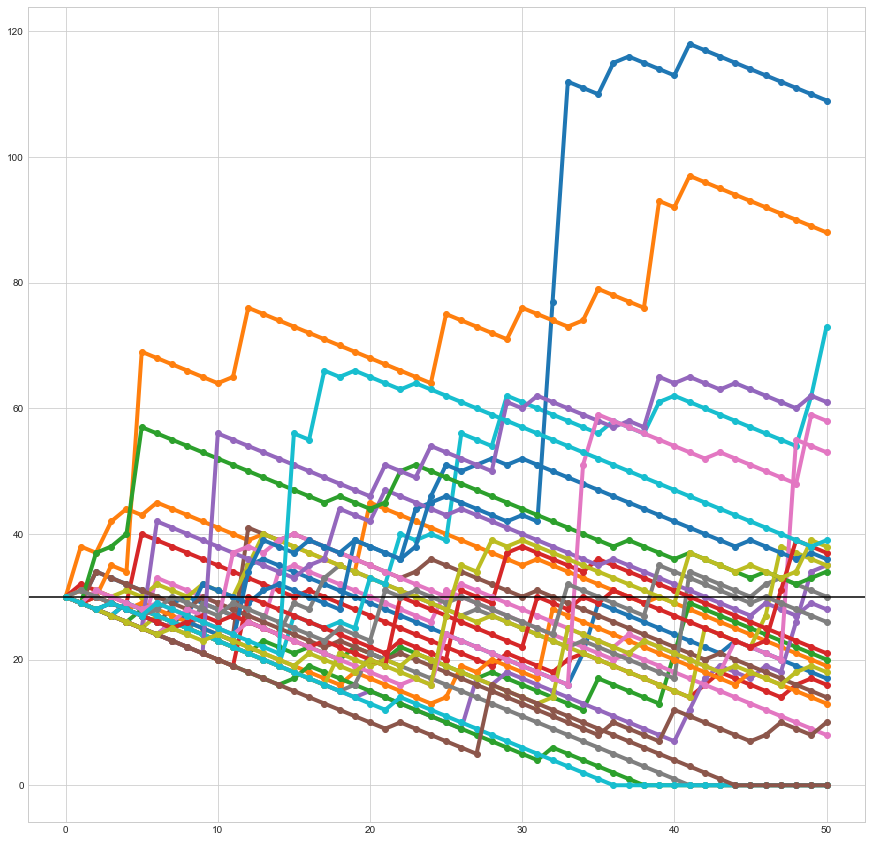

In [22]:
plot_chips_evolution(chips)

Por último, vamos a mostra rle histograma de frecuencia de la cantidad de fichas con las que le jugador es capaz de salir del casino a lo largo de un mes. 

(0, 157.4341804981768)

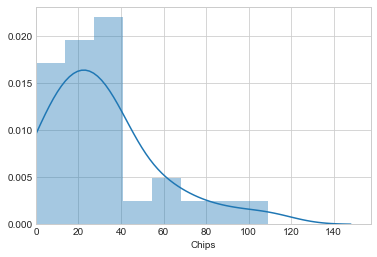

In [23]:
sns.distplot(df['Chips']);plt.xlim(0,None)

###           c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?

In [24]:
ruined = df[df['Chips'] == 0]
ruined

,Day,Chips,Games,Benefit,Improvement
12,13,0,38,-30,-1.0
17,18,0,41,-30,-1.0
19,20,0,36,-30,-1.0
25,26,0,44,-30,-1.0


In [25]:
"El jugador se ha arruinado "+ str(ruined.shape[0]) +" veces, jugando de media " + str(round(ruined["Games"].mean(),2)) + " días antes de arruinarse."

'El jugador se ha arruinado 4 veces, jugando de media 39.75 días antes de arruinarse.'

####          Estadísticos de esta primera simulación
Aunque esta sección no estaba requerida en el enunicado de la memoria a continuación se muestran  diferentes estadísticos sencillos que pueden ayudarnos a comprender mejor el resultado de la simulación. 

In [26]:
df.describe()

,Day,Chips,Games,Benefit,Improvement
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.500000,31.200000,48.633333,1.200000,0.040000
std,8.803408,26.156558,3.718392,26.156558,0.871885
min,1.000000,0.000000,36.000000,-30.000000,-1.000000
25%,8.250000,14.500000,50.000000,-15.500000,-0.516667
50%,15.500000,27.000000,50.000000,-3.000000,-0.100000
75%,22.750000,37.750000,50.000000,7.750000,0.258333
max,30.000000,109.000000,50.000000,79.000000,2.633333


### Análisis de los resultados en media

In [27]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 50
INITIAL_CHIPS = 30
DAYS = 30

In [28]:
months = [simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)  for i  in range(1000)]

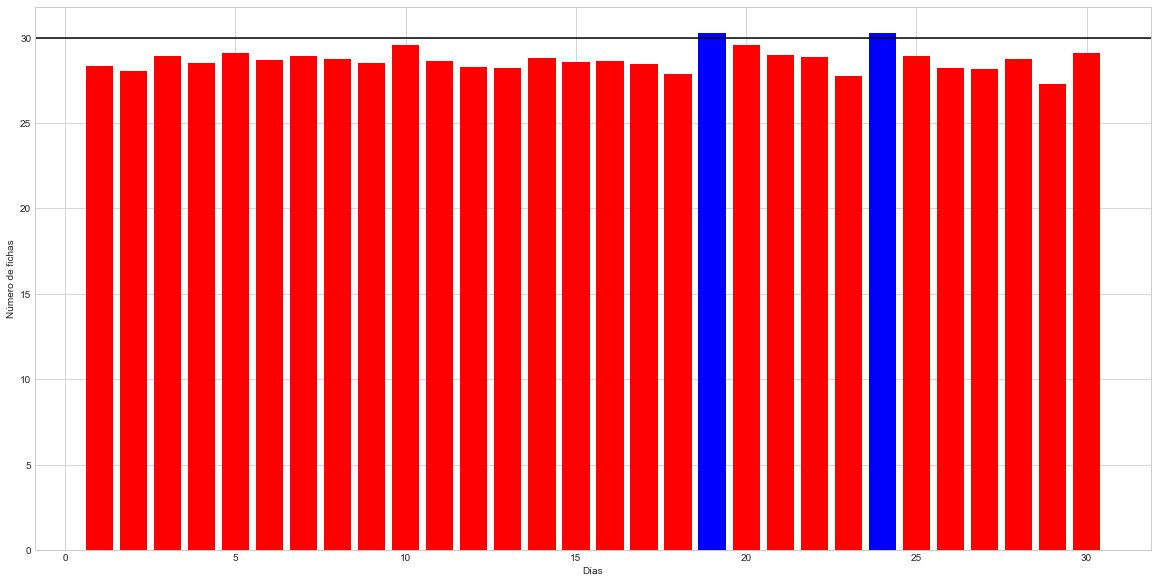

In [29]:
simulations = []
chips = []
games = []
for s, c, g  in months:
    simulations.append(s)
    chips.append(c)
    games.append(g)
    
chips = np.array(chips)
chips_avg = chips.sum(0)/len(chips)
games = np.array(games)
games_avg = games.sum(0)/len(games)
df = create_df(chips_avg, games_avg)
plot_bar_graph(df, INITIAL_CHIPS)

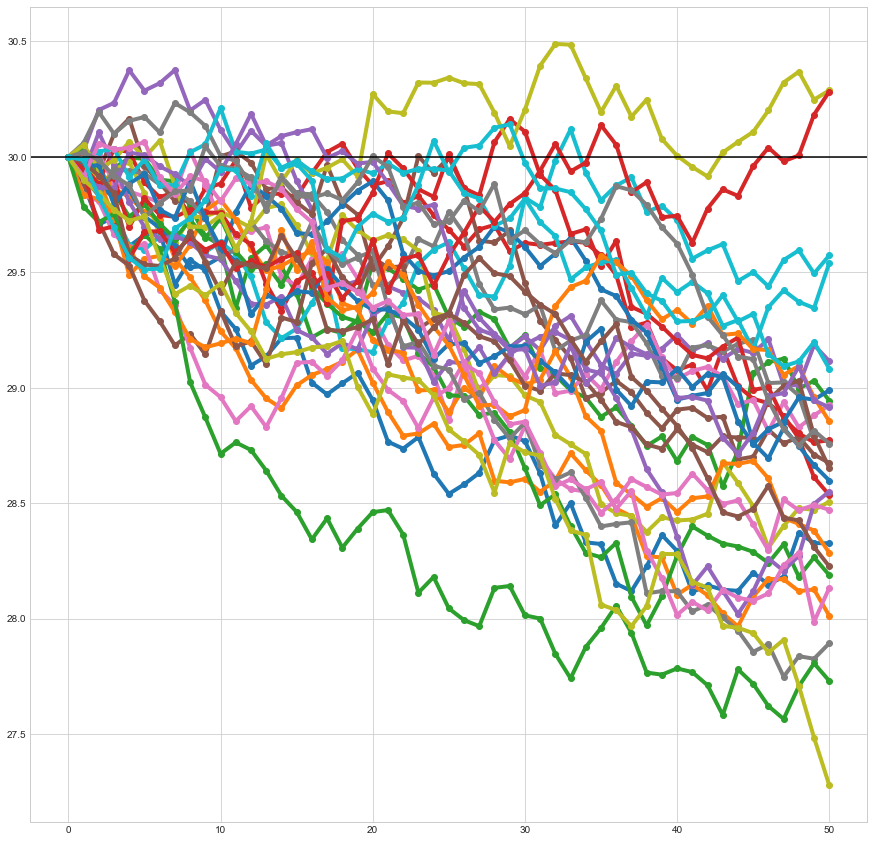

In [30]:
plot_chips_evolution(chips_avg)

(0, 31.515323668342266)

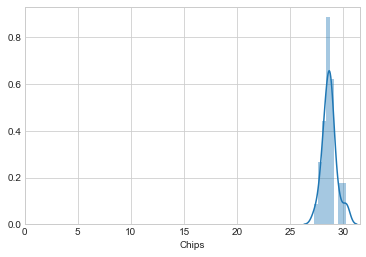

In [31]:
sns.distplot(df['Chips']);plt.xlim(0,None)

### Análisis de la distribución
En esta ocasión vamos a olvidarnos del problema en si y vamos a estudiar como se comporta la distribución de las fichas obtenidas al final devarias noches


(0, 157.28544623443764)

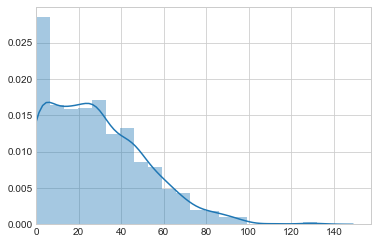

In [40]:
bet_eq_fc = []
for i in range (1000):
    _, chips_eq, _ = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, 1)
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq) 
    bet_eq_fc.append(chips_eq[0][-1])

sns.distplot(bet_eq_fc);plt.xlim(0,None)

In [41]:
pd.DataFrame(bet_eq_fc).describe() 

,0
count,1000.000000
mean,28.743000
std,22.553128
min,0.000000
25%,10.000000
50%,26.000000
75%,44.000000
max,132.000000


## Ejercicio 2:    Si analizamos el problema a largo plazo, jugando partidas indefinidamente, y empezando con 30 fichas ¿cuál es la probabilidad de que me quede sin dinero? ¿y la de que termine con 150 fichas?

In [34]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 4000
INITIAL_CHIPS = 30
DAYS = 1000

In [35]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

La simulación se ha realizado, veaos cual es el resultado obtenido a lo largo del mes: 

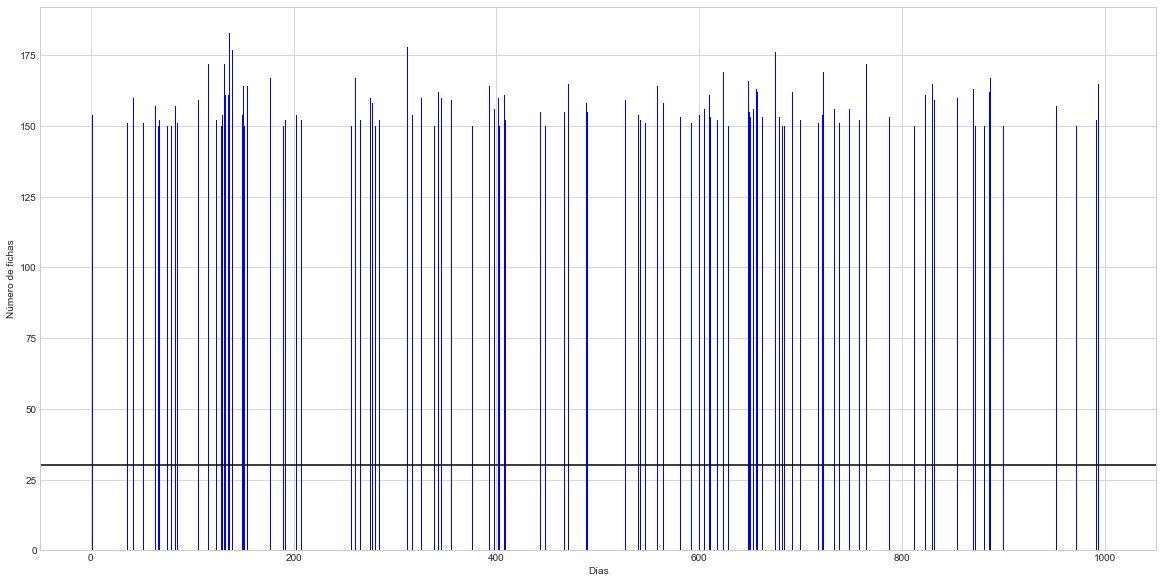

In [36]:
plot_bar_graph(df, INITIAL_CHIPS)

In [37]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 864
Porcentaje de noches que el jugador perdió todas las fichas: 86.4%
Número de noches que el jugador perdió fichas: 864
Porcentaje de noches que el jugador perdió fichas: 86.4%
Número de noches que el jugador salió igual del casino: 0
Porcentaje de noches que el jugador salió igual del casino: 0.0%
Número de noches que el jugador ganó fichas: 136
Porcentaje de noches que el jugador ganó fichas: 13.6%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 136
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 13.6%


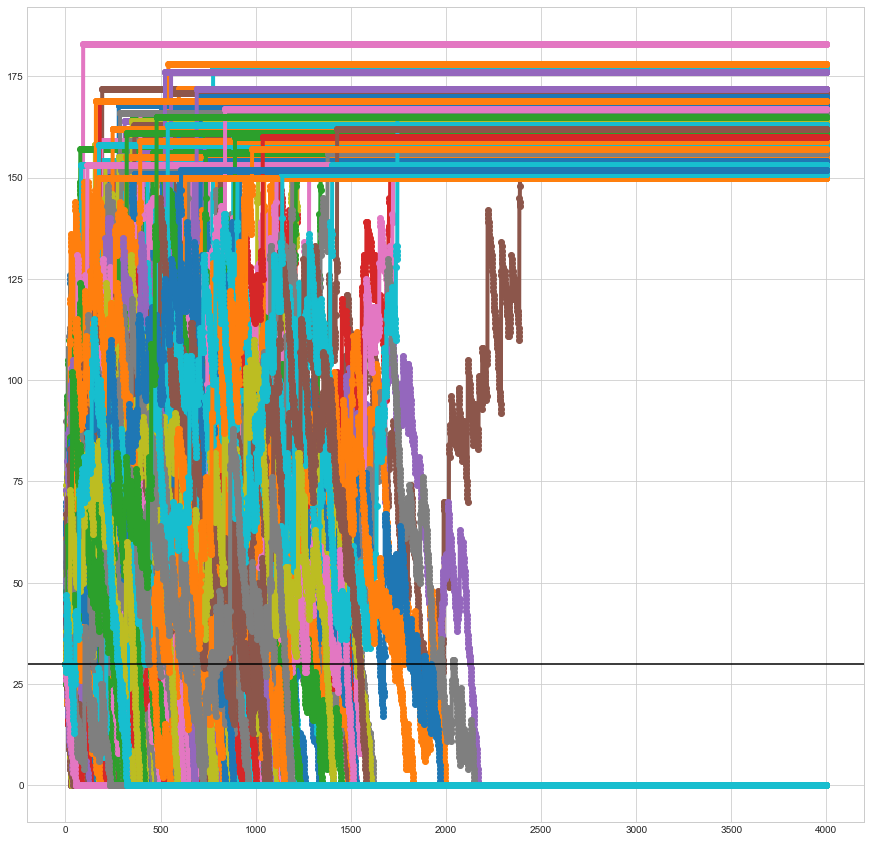

In [38]:
plot_chips_evolution(chips)

In [39]:
df.describe()

,Day,Chips,Games,Benefit,Improvement
count,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,500.500000,21.39400,776.137000,-8.60600,-0.286867
std,288.819436,54.01565,1317.017346,54.01565,1.800522
min,1.000000,0.00000,30.000000,-30.00000,-1.000000
25%,250.750000,0.00000,76.000000,-30.00000,-1.000000
50%,500.500000,0.00000,173.000000,-30.00000,-1.000000
75%,750.250000,0.00000,593.000000,-30.00000,-1.000000
max,1000.000000,183.00000,4000.000000,153.00000,5.100000


### Cálculo de la matriz estacionaria

In [40]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq)
elevate_matrix_n = 10**9
chips_start = 30
matrix_future = matrix_power(np.array(matrix), elevate_matrix_n)
print("El porcentaje exacto de perder todas las fichas, empezando con %s es: %s" %(chips_start, matrix_future[chips_start][0]))
print("Matriz elevada a %s"%elevate_matrix_n)
pd.DataFrame(matrix_future).head()

El porcentaje exacto de perder todas las fichas, empezando con 30 es: 0.8618635964960594
Matriz elevada a 1000000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.995705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000619,0.000482,0.000399,0.000350,0.000302,0.000254,0.000224,0.000194,0.000164,0.000146,0.000128,0.000110,0.000100,0.000091,0.000082,0.000073,0.000064,0.000055,0.000052,0.000048,0.000045,0.000042,0.000039,0.000036,0.000033,0.00003,0.000027,0.000024,0.000021,0.000018,0.000015,0.000012,0.000009,0.000006,0.000003
2,0.991390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001241,0.000967,0.000799,0.000702,0.000606,0.000510,0.000449,0.000389,0.000329,0.000292,0.000256,0.000220,0.000201,0.000183,0.000164,0.000146,0.000128,0.000110,0.000103,0.000097,0.000091,0.000085,0.000078,0.000072,0.000066,0.00006,0.000054,0.000048,0.000042,0.000036,0.000030,0.000024,0.000018,0.000012,0.000006
3,0.987055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Comparación: Cálculo de precisión
Comparación simulación con diferentes inicios contra el método exacto

In [43]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 4000
INITIAL_CHIPS_A = [1,50,100,120,149]
DAYS = 500
result_simulations = []
for init_chips_night in INITIAL_CHIPS_A:
  simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, init_chips_night, DAYS)
  result_simulations.append({
      'init_chips': init_chips_night,
      'df': create_df(chips, games)
  })
# Calculate matrix
n_infinite = 10**9
matrix_future = matrix_power(np.array(matrix), n_infinite)
print(n_infinite, matrix_future[30][0])

1000000000 0.8618635964960594


In [46]:
# Comparacion
for simulation_i in result_simulations:
  init_chips = simulation_i['init_chips']
  df = simulation_i['df']
  p_lose_simulation = np.count_nonzero(df['Chips']==0)/DAYS
  p_lose_matrix = matrix_future[init_chips][0]

  print("==========================",)
  print("Init chips: %s" % init_chips)
  print("p_lose_simulation:",p_lose_simulation)
  print("p_lose_matrix:",p_lose_matrix)
  print("Error en precisión simulación:",abs(p_lose_matrix-p_lose_simulation))

Init chips: 1
p_lose_simulation: 1.0
p_lose_matrix: 0.9957054429110437
Error en precisión simulación: 0.004294557088956319
Init chips: 50
p_lose_simulation: 0.74
p_lose_matrix: 0.7582135952446913
Error en precisión simulación: 0.01821359524469135
Init chips: 100
p_lose_simulation: 0.45
p_lose_matrix: 0.4517026316408317
Error en precisión simulación: 0.0017026316408316755
Init chips: 120
p_lose_simulation: 0.308
p_lose_matrix: 0.30641200484965236
Error en precisión simulación: 0.001587995150347632
Init chips: 149
p_lose_simulation: 0.072
p_lose_matrix: 0.06251615052746358
Error en precisión simulación: 0.009483849472536415


## Ejercicio 3:  ¿Con qué probabilidad debería jugar a cada una de las partidas para que el beneficio medio de cada noche sea máximo? Utilícese la metaheurística recocido simulado.


###  Elementos del algoritmo

#### Constructivo

In [48]:
def inicializador_aleatorio(bets):
    x = []
    for i in range(len(bets)):
        x.append(randrange(100))
    suma = np.sum(x)
    x = x/suma
    return x

def inicializador_equiprobable(bets):
    return [float(1/len(bets))]*len(bets)

#### Estructura de Vecindad

In [49]:
def vecindad(x, delta=0.2, c=2):
    for i in range(c):
        j = randrange(len(x))
        x[j] = x[j] + delta
    suma = np.sum(x)
    x = x/suma
    return x

#### Probailidad de Aceptación

In [50]:
def probabilidad_aceptacion(y, y_nuevo, temperatura):
    # si mejora la solución actual se acepta siempre
    if y_nuevo > y:
        return 1
    # en caso contrario, la aceptación dependerá de la temperatura,
    # a medida que avanza el problema menor temperatura, menor probabilidad de aceptación
    else:
        probabilidad = np.exp(- (y - y_nuevo) / temperatura)
        return probabilidad

#### Función Objetivo

In [51]:
def fo(chips, games):
    final_chips = [x[-1] for x in chips]
    return sum(final_chips) / len(final_chips) 

def fo_v2(chips, games, k2=0.1):
    final_chips = [x[-1] for x in chips]
    return  (sum(final_chips)/ len(final_chips)) + k2 * (sum(games) / len(games))

### Ejecución del algoritmo

In [52]:
def recocido_simulado(funcion, vecindad, x_inicial, probabilidad_aceptacion, max_iteraciones, informacion,initial_temp, descanso, alpha, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS, bets, LEAVE_WITH_MIN, LEAVE_WITH_MAX):
    T = T_i = float(initial_temp)
    x = x_inicial
    num = 1
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, x)
    _, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
    y = funcion(chips, games)
    valores_x, valores_y = [x], [y]
    valores_t = []
    for iteracion in range(max_iteraciones+1):
        valores_t.append(T)
        x_vecina = vecindad(x.copy())
        matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, x_vecina)
        _, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
        y_vecina = funcion(chips, games)
        if informacion == 1:
            print(
                "Iteracion {:>2}/{:>2} : T = {:>4.3g}, y = {:>4.3g}, y_vecina = {:>4.3g}".format(
                    iteracion, max_iteraciones, T, y, y_vecina))
        if probabilidad_aceptacion(y, y_vecina, T) > rnd.random():
            x, y = x_vecina, y_vecina
        valores_x.append(x)
        valores_y.append(y)
        if iteracion % descanso == 0:
            T = T_i*(alpha**num)
            num += 1
    return x, valores_y[-1], valores_x, valores_y, valores_t

In [53]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 50
INITIAL_CHIPS = 30
DAYS = 30
gambling_random = np.random
gambling_random.seed(42)

### Ajuste de parámetros

#### Constructivo
Se van a comparar los métodos de construcción de soluciones equiprobables y aleatorias. Para ello, se van a construir un número de soluciones determinada y a comprar los resultados de la simulación. 

[/]


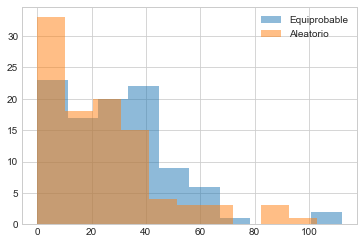

In [54]:
bet_eq_fc = []
bet_al_fc = []
print("[", end = '')
for i in range (100):
    bet_eq = inicializador_equiprobable(bets)
    bet_al = inicializador_aleatorio(bets)
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, bet_eq)
    _, chips_eq, _ = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, 1)
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, bet_al)
    _, chips_al, _ = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, 1)
    bet_eq_fc.append(chips_eq[0][-1])
    bet_al_fc.append(chips_al[0][-1])
    if i % 1000 == 0: print("/", end = '')
print("]")

plt.hist(bet_eq_fc, alpha=0.5, label='Equiprobable')
plt.hist(bet_al_fc, alpha=0.5, label='Aleatorio')
plt.legend(loc='upper right')
plt.show()

In [55]:
dic = {"Equiprobable": bet_eq_fc, "Aleatorio": bet_al_fc}
pd.DataFrame(dic,).describe() 

,Equiprobable,Aleatorio
count,100.000000,100.000000
mean,28.850000,23.730000
std,21.281839,21.787706
min,0.000000,0.000000
25%,14.000000,7.000000
50%,27.500000,20.000000
75%,40.000000,33.500000
max,112.000000,103.000000


### Visualización de los resultados del algoritmo

In [56]:
gambling_random = np.random
gambling_random.seed(42)
x, y, valores_x, valores_y, valores_t = recocido_simulado(fo, vecindad, inicializador_aleatorio(bets), probabilidad_aceptacion,2000,1,5,150,0.85,gambling_random, NUM_GAMES, INITIAL_CHIPS, DAYS, bets, LEAVE_WITH_MIN, LEAVE_WITH_MAX)

Iteracion  0/2000 : T =    5, y = 28.8, y_vecina = 31.1
Iteracion  1/2000 : T = 4.25, y = 31.1, y_vecina = 22.7
Iteracion  2/2000 : T = 4.25, y = 31.1, y_vecina = 30.5
Iteracion  3/2000 : T = 4.25, y = 30.5, y_vecina = 25.6
Iteracion  4/2000 : T = 4.25, y = 25.6, y_vecina = 17.5
Iteracion  5/2000 : T = 4.25, y = 25.6, y_vecina = 25.8
Iteracion  6/2000 : T = 4.25, y = 25.8, y_vecina = 29.3
Iteracion  7/2000 : T = 4.25, y = 29.3, y_vecina = 33.9
Iteracion  8/2000 : T = 4.25, y = 33.9, y_vecina = 30.3
Iteracion  9/2000 : T = 4.25, y = 33.9, y_vecina = 28.2
Iteracion 10/2000 : T = 4.25, y = 28.2, y_vecina = 26.1
Iteracion 11/2000 : T = 4.25, y = 28.2, y_vecina = 44.2
Iteracion 12/2000 : T = 4.25, y = 44.2, y_vecina =   32
Iteracion 13/2000 : T = 4.25, y = 44.2, y_vecina = 33.9
Iteracion 14/2000 : T = 4.25, y = 44.2, y_vecina =   33
Iteracion 15/2000 : T = 4.25, y = 44.2, y_vecina = 30.2
Iteracion 16/2000 : T = 4.25, y = 44.2, y_vecina = 25.9
Iteracion 17/2000 : T = 4.25, y = 44.2, y_vecina

Iteracion 146/2000 : T = 4.25, y =   34, y_vecina = 28.5
Iteracion 147/2000 : T = 4.25, y =   34, y_vecina = 27.1
Iteracion 148/2000 : T = 4.25, y = 27.1, y_vecina = 30.8
Iteracion 149/2000 : T = 4.25, y = 30.8, y_vecina = 33.4
Iteracion 150/2000 : T = 4.25, y = 33.4, y_vecina = 29.3
Iteracion 151/2000 : T = 3.61, y = 33.4, y_vecina = 31.8
Iteracion 152/2000 : T = 3.61, y = 33.4, y_vecina = 33.9
Iteracion 153/2000 : T = 3.61, y = 33.9, y_vecina = 33.2
Iteracion 154/2000 : T = 3.61, y = 33.2, y_vecina = 29.6
Iteracion 155/2000 : T = 3.61, y = 29.6, y_vecina = 31.1
Iteracion 156/2000 : T = 3.61, y = 31.1, y_vecina = 33.7
Iteracion 157/2000 : T = 3.61, y = 33.7, y_vecina = 27.2
Iteracion 158/2000 : T = 3.61, y = 33.7, y_vecina = 31.4
Iteracion 159/2000 : T = 3.61, y = 31.4, y_vecina =   35
Iteracion 160/2000 : T = 3.61, y =   35, y_vecina = 28.6
Iteracion 161/2000 : T = 3.61, y = 28.6, y_vecina = 31.5
Iteracion 162/2000 : T = 3.61, y = 31.5, y_vecina = 33.5
Iteracion 163/2000 : T = 3.61, 

Iteracion 291/2000 : T = 3.61, y = 21.3, y_vecina = 25.1
Iteracion 292/2000 : T = 3.61, y = 25.1, y_vecina = 24.8
Iteracion 293/2000 : T = 3.61, y = 24.8, y_vecina = 41.7
Iteracion 294/2000 : T = 3.61, y = 41.7, y_vecina = 32.9
Iteracion 295/2000 : T = 3.61, y = 41.7, y_vecina = 35.4
Iteracion 296/2000 : T = 3.61, y = 41.7, y_vecina = 27.9
Iteracion 297/2000 : T = 3.61, y = 27.9, y_vecina = 24.7
Iteracion 298/2000 : T = 3.61, y = 27.9, y_vecina = 28.5
Iteracion 299/2000 : T = 3.61, y = 28.5, y_vecina = 25.2
Iteracion 300/2000 : T = 3.61, y = 28.5, y_vecina = 35.3
Iteracion 301/2000 : T = 3.07, y = 35.3, y_vecina = 21.3
Iteracion 302/2000 : T = 3.07, y = 21.3, y_vecina = 28.9
Iteracion 303/2000 : T = 3.07, y = 28.9, y_vecina = 29.3
Iteracion 304/2000 : T = 3.07, y = 29.3, y_vecina = 29.1
Iteracion 305/2000 : T = 3.07, y = 29.1, y_vecina = 30.2
Iteracion 306/2000 : T = 3.07, y = 30.2, y_vecina = 22.4
Iteracion 307/2000 : T = 3.07, y = 30.2, y_vecina = 27.1
Iteracion 308/2000 : T = 3.07, 

Iteracion 438/2000 : T = 3.07, y = 42.7, y_vecina = 28.8
Iteracion 439/2000 : T = 3.07, y = 42.7, y_vecina = 27.3
Iteracion 440/2000 : T = 3.07, y = 42.7, y_vecina = 20.6
Iteracion 441/2000 : T = 3.07, y = 42.7, y_vecina = 22.4
Iteracion 442/2000 : T = 3.07, y = 42.7, y_vecina = 33.9
Iteracion 443/2000 : T = 3.07, y = 42.7, y_vecina = 30.5
Iteracion 444/2000 : T = 3.07, y = 42.7, y_vecina = 23.9
Iteracion 445/2000 : T = 3.07, y = 42.7, y_vecina =   32
Iteracion 446/2000 : T = 3.07, y = 42.7, y_vecina = 23.9
Iteracion 447/2000 : T = 3.07, y = 42.7, y_vecina = 24.7
Iteracion 448/2000 : T = 3.07, y = 42.7, y_vecina = 25.3
Iteracion 449/2000 : T = 3.07, y = 42.7, y_vecina = 33.9
Iteracion 450/2000 : T = 3.07, y = 42.7, y_vecina = 35.7
Iteracion 451/2000 : T = 2.61, y = 42.7, y_vecina = 36.6
Iteracion 452/2000 : T = 2.61, y = 42.7, y_vecina =   30
Iteracion 453/2000 : T = 2.61, y = 42.7, y_vecina = 25.4
Iteracion 454/2000 : T = 2.61, y = 42.7, y_vecina = 33.3
Iteracion 455/2000 : T = 2.61, 

Iteracion 583/2000 : T = 2.61, y = 42.3, y_vecina =   27
Iteracion 584/2000 : T = 2.61, y = 42.3, y_vecina = 26.8
Iteracion 585/2000 : T = 2.61, y = 42.3, y_vecina = 37.8
Iteracion 586/2000 : T = 2.61, y = 42.3, y_vecina = 28.8
Iteracion 587/2000 : T = 2.61, y = 42.3, y_vecina = 30.9
Iteracion 588/2000 : T = 2.61, y = 42.3, y_vecina = 26.1
Iteracion 589/2000 : T = 2.61, y = 42.3, y_vecina = 25.9
Iteracion 590/2000 : T = 2.61, y = 42.3, y_vecina = 30.3
Iteracion 591/2000 : T = 2.61, y = 42.3, y_vecina = 33.1
Iteracion 592/2000 : T = 2.61, y = 42.3, y_vecina = 29.8
Iteracion 593/2000 : T = 2.61, y = 42.3, y_vecina = 29.6
Iteracion 594/2000 : T = 2.61, y = 42.3, y_vecina = 28.8
Iteracion 595/2000 : T = 2.61, y = 42.3, y_vecina = 28.9
Iteracion 596/2000 : T = 2.61, y = 42.3, y_vecina = 39.5
Iteracion 597/2000 : T = 2.61, y = 42.3, y_vecina = 29.3
Iteracion 598/2000 : T = 2.61, y = 42.3, y_vecina = 25.8
Iteracion 599/2000 : T = 2.61, y = 42.3, y_vecina = 26.4
Iteracion 600/2000 : T = 2.61, 

Iteracion 730/2000 : T = 2.22, y = 32.3, y_vecina = 28.4
Iteracion 731/2000 : T = 2.22, y = 32.3, y_vecina = 34.5
Iteracion 732/2000 : T = 2.22, y = 34.5, y_vecina = 29.9
Iteracion 733/2000 : T = 2.22, y = 34.5, y_vecina = 22.2
Iteracion 734/2000 : T = 2.22, y = 34.5, y_vecina = 21.7
Iteracion 735/2000 : T = 2.22, y = 34.5, y_vecina = 30.9
Iteracion 736/2000 : T = 2.22, y = 34.5, y_vecina = 24.5
Iteracion 737/2000 : T = 2.22, y = 34.5, y_vecina = 24.3
Iteracion 738/2000 : T = 2.22, y = 34.5, y_vecina = 23.6
Iteracion 739/2000 : T = 2.22, y = 34.5, y_vecina = 20.8
Iteracion 740/2000 : T = 2.22, y = 34.5, y_vecina = 29.3
Iteracion 741/2000 : T = 2.22, y = 34.5, y_vecina =   24
Iteracion 742/2000 : T = 2.22, y = 34.5, y_vecina = 28.1
Iteracion 743/2000 : T = 2.22, y = 34.5, y_vecina = 22.6
Iteracion 744/2000 : T = 2.22, y = 34.5, y_vecina = 32.9
Iteracion 745/2000 : T = 2.22, y = 32.9, y_vecina = 23.1
Iteracion 746/2000 : T = 2.22, y = 32.9, y_vecina = 34.3
Iteracion 747/2000 : T = 2.22, 

Iteracion 877/2000 : T = 1.89, y = 38.8, y_vecina = 29.1
Iteracion 878/2000 : T = 1.89, y = 38.8, y_vecina = 25.4
Iteracion 879/2000 : T = 1.89, y = 38.8, y_vecina = 24.5
Iteracion 880/2000 : T = 1.89, y = 38.8, y_vecina = 27.2
Iteracion 881/2000 : T = 1.89, y = 38.8, y_vecina = 27.4
Iteracion 882/2000 : T = 1.89, y = 38.8, y_vecina = 27.4
Iteracion 883/2000 : T = 1.89, y = 38.8, y_vecina = 29.2
Iteracion 884/2000 : T = 1.89, y = 38.8, y_vecina = 29.3
Iteracion 885/2000 : T = 1.89, y = 38.8, y_vecina =   23
Iteracion 886/2000 : T = 1.89, y = 38.8, y_vecina = 28.9
Iteracion 887/2000 : T = 1.89, y = 38.8, y_vecina = 27.1
Iteracion 888/2000 : T = 1.89, y = 38.8, y_vecina = 28.2
Iteracion 889/2000 : T = 1.89, y = 38.8, y_vecina = 27.4
Iteracion 890/2000 : T = 1.89, y = 38.8, y_vecina = 28.8
Iteracion 891/2000 : T = 1.89, y = 38.8, y_vecina = 33.9
Iteracion 892/2000 : T = 1.89, y = 38.8, y_vecina = 30.3
Iteracion 893/2000 : T = 1.89, y = 38.8, y_vecina = 25.3
Iteracion 894/2000 : T = 1.89, 

Iteracion 1024/2000 : T =  1.6, y = 42.5, y_vecina = 34.6
Iteracion 1025/2000 : T =  1.6, y = 42.5, y_vecina = 27.1
Iteracion 1026/2000 : T =  1.6, y = 42.5, y_vecina = 32.7
Iteracion 1027/2000 : T =  1.6, y = 42.5, y_vecina = 22.2
Iteracion 1028/2000 : T =  1.6, y = 42.5, y_vecina = 25.9
Iteracion 1029/2000 : T =  1.6, y = 42.5, y_vecina = 21.8
Iteracion 1030/2000 : T =  1.6, y = 42.5, y_vecina = 20.1
Iteracion 1031/2000 : T =  1.6, y = 42.5, y_vecina = 32.3
Iteracion 1032/2000 : T =  1.6, y = 42.5, y_vecina = 31.6
Iteracion 1033/2000 : T =  1.6, y = 42.5, y_vecina = 28.5
Iteracion 1034/2000 : T =  1.6, y = 42.5, y_vecina = 26.5
Iteracion 1035/2000 : T =  1.6, y = 42.5, y_vecina = 25.4
Iteracion 1036/2000 : T =  1.6, y = 42.5, y_vecina = 27.1
Iteracion 1037/2000 : T =  1.6, y = 42.5, y_vecina = 30.4
Iteracion 1038/2000 : T =  1.6, y = 42.5, y_vecina = 35.6
Iteracion 1039/2000 : T =  1.6, y = 42.5, y_vecina = 26.1
Iteracion 1040/2000 : T =  1.6, y = 42.5, y_vecina = 33.3
Iteracion 1041

Iteracion 1169/2000 : T = 1.36, y = 34.8, y_vecina = 33.3
Iteracion 1170/2000 : T = 1.36, y = 33.3, y_vecina = 22.4
Iteracion 1171/2000 : T = 1.36, y = 33.3, y_vecina = 33.9
Iteracion 1172/2000 : T = 1.36, y = 33.9, y_vecina = 27.1
Iteracion 1173/2000 : T = 1.36, y = 33.9, y_vecina = 26.1
Iteracion 1174/2000 : T = 1.36, y = 33.9, y_vecina = 27.7
Iteracion 1175/2000 : T = 1.36, y = 33.9, y_vecina = 22.6
Iteracion 1176/2000 : T = 1.36, y = 33.9, y_vecina = 30.8
Iteracion 1177/2000 : T = 1.36, y = 33.9, y_vecina = 25.7
Iteracion 1178/2000 : T = 1.36, y = 33.9, y_vecina = 27.4
Iteracion 1179/2000 : T = 1.36, y = 33.9, y_vecina =   35
Iteracion 1180/2000 : T = 1.36, y =   35, y_vecina = 26.5
Iteracion 1181/2000 : T = 1.36, y =   35, y_vecina = 28.6
Iteracion 1182/2000 : T = 1.36, y =   35, y_vecina = 29.5
Iteracion 1183/2000 : T = 1.36, y =   35, y_vecina = 33.6
Iteracion 1184/2000 : T = 1.36, y = 33.6, y_vecina = 24.4
Iteracion 1185/2000 : T = 1.36, y = 33.6, y_vecina = 30.2
Iteracion 1186

Iteracion 1313/2000 : T = 1.16, y = 35.3, y_vecina = 27.4
Iteracion 1314/2000 : T = 1.16, y = 35.3, y_vecina = 29.3
Iteracion 1315/2000 : T = 1.16, y = 35.3, y_vecina = 34.2
Iteracion 1316/2000 : T = 1.16, y = 35.3, y_vecina = 28.2
Iteracion 1317/2000 : T = 1.16, y = 35.3, y_vecina = 29.6
Iteracion 1318/2000 : T = 1.16, y = 35.3, y_vecina = 31.6
Iteracion 1319/2000 : T = 1.16, y = 35.3, y_vecina = 38.2
Iteracion 1320/2000 : T = 1.16, y = 38.2, y_vecina = 32.1
Iteracion 1321/2000 : T = 1.16, y = 38.2, y_vecina = 23.8
Iteracion 1322/2000 : T = 1.16, y = 38.2, y_vecina = 24.3
Iteracion 1323/2000 : T = 1.16, y = 38.2, y_vecina = 29.1
Iteracion 1324/2000 : T = 1.16, y = 38.2, y_vecina = 20.1
Iteracion 1325/2000 : T = 1.16, y = 38.2, y_vecina =   30
Iteracion 1326/2000 : T = 1.16, y = 38.2, y_vecina = 23.2
Iteracion 1327/2000 : T = 1.16, y = 38.2, y_vecina = 31.3
Iteracion 1328/2000 : T = 1.16, y = 38.2, y_vecina = 36.4
Iteracion 1329/2000 : T = 1.16, y = 38.2, y_vecina =   21
Iteracion 1330

Iteracion 1453/2000 : T = 0.984, y = 43.6, y_vecina = 32.3
Iteracion 1454/2000 : T = 0.984, y = 43.6, y_vecina = 40.3
Iteracion 1455/2000 : T = 0.984, y = 43.6, y_vecina = 25.9
Iteracion 1456/2000 : T = 0.984, y = 43.6, y_vecina = 27.5
Iteracion 1457/2000 : T = 0.984, y = 43.6, y_vecina = 25.5
Iteracion 1458/2000 : T = 0.984, y = 43.6, y_vecina = 24.8
Iteracion 1459/2000 : T = 0.984, y = 43.6, y_vecina = 28.2
Iteracion 1460/2000 : T = 0.984, y = 43.6, y_vecina = 21.6
Iteracion 1461/2000 : T = 0.984, y = 43.6, y_vecina =   18
Iteracion 1462/2000 : T = 0.984, y = 43.6, y_vecina = 23.6
Iteracion 1463/2000 : T = 0.984, y = 43.6, y_vecina = 27.7
Iteracion 1464/2000 : T = 0.984, y = 43.6, y_vecina = 30.2
Iteracion 1465/2000 : T = 0.984, y = 43.6, y_vecina = 32.5
Iteracion 1466/2000 : T = 0.984, y = 43.6, y_vecina = 26.7
Iteracion 1467/2000 : T = 0.984, y = 43.6, y_vecina = 20.1
Iteracion 1468/2000 : T = 0.984, y = 43.6, y_vecina = 30.6
Iteracion 1469/2000 : T = 0.984, y = 43.6, y_vecina = 27

Iteracion 1593/2000 : T = 0.837, y = 44.2, y_vecina = 31.5
Iteracion 1594/2000 : T = 0.837, y = 44.2, y_vecina = 24.8
Iteracion 1595/2000 : T = 0.837, y = 44.2, y_vecina = 27.1
Iteracion 1596/2000 : T = 0.837, y = 44.2, y_vecina = 30.3
Iteracion 1597/2000 : T = 0.837, y = 44.2, y_vecina = 30.8
Iteracion 1598/2000 : T = 0.837, y = 44.2, y_vecina = 28.7
Iteracion 1599/2000 : T = 0.837, y = 44.2, y_vecina = 24.7
Iteracion 1600/2000 : T = 0.837, y = 44.2, y_vecina = 31.7
Iteracion 1601/2000 : T = 0.837, y = 44.2, y_vecina = 25.2
Iteracion 1602/2000 : T = 0.837, y = 44.2, y_vecina = 25.2
Iteracion 1603/2000 : T = 0.837, y = 44.2, y_vecina = 25.1
Iteracion 1604/2000 : T = 0.837, y = 44.2, y_vecina = 20.3
Iteracion 1605/2000 : T = 0.837, y = 44.2, y_vecina = 24.6
Iteracion 1606/2000 : T = 0.837, y = 44.2, y_vecina = 25.6
Iteracion 1607/2000 : T = 0.837, y = 44.2, y_vecina = 27.8
Iteracion 1608/2000 : T = 0.837, y = 44.2, y_vecina = 27.2
Iteracion 1609/2000 : T = 0.837, y = 44.2, y_vecina = 30

Iteracion 1736/2000 : T = 0.711, y = 44.2, y_vecina = 24.7
Iteracion 1737/2000 : T = 0.711, y = 44.2, y_vecina = 35.8
Iteracion 1738/2000 : T = 0.711, y = 44.2, y_vecina = 28.1
Iteracion 1739/2000 : T = 0.711, y = 44.2, y_vecina = 28.8
Iteracion 1740/2000 : T = 0.711, y = 44.2, y_vecina = 30.3
Iteracion 1741/2000 : T = 0.711, y = 44.2, y_vecina = 35.9
Iteracion 1742/2000 : T = 0.711, y = 44.2, y_vecina = 30.9
Iteracion 1743/2000 : T = 0.711, y = 44.2, y_vecina =   27
Iteracion 1744/2000 : T = 0.711, y = 44.2, y_vecina = 25.3
Iteracion 1745/2000 : T = 0.711, y = 44.2, y_vecina = 39.6
Iteracion 1746/2000 : T = 0.711, y = 44.2, y_vecina = 26.1
Iteracion 1747/2000 : T = 0.711, y = 44.2, y_vecina = 26.6
Iteracion 1748/2000 : T = 0.711, y = 44.2, y_vecina =   25
Iteracion 1749/2000 : T = 0.711, y = 44.2, y_vecina = 27.5
Iteracion 1750/2000 : T = 0.711, y = 44.2, y_vecina =   31
Iteracion 1751/2000 : T = 0.711, y = 44.2, y_vecina = 29.2
Iteracion 1752/2000 : T = 0.711, y = 44.2, y_vecina =   

Iteracion 1875/2000 : T = 0.605, y = 44.2, y_vecina = 32.6
Iteracion 1876/2000 : T = 0.605, y = 44.2, y_vecina = 25.8
Iteracion 1877/2000 : T = 0.605, y = 44.2, y_vecina = 32.6
Iteracion 1878/2000 : T = 0.605, y = 44.2, y_vecina = 28.2
Iteracion 1879/2000 : T = 0.605, y = 44.2, y_vecina = 24.4
Iteracion 1880/2000 : T = 0.605, y = 44.2, y_vecina = 29.6
Iteracion 1881/2000 : T = 0.605, y = 44.2, y_vecina = 28.6
Iteracion 1882/2000 : T = 0.605, y = 44.2, y_vecina = 32.5
Iteracion 1883/2000 : T = 0.605, y = 44.2, y_vecina = 28.8
Iteracion 1884/2000 : T = 0.605, y = 44.2, y_vecina =   21
Iteracion 1885/2000 : T = 0.605, y = 44.2, y_vecina = 27.1
Iteracion 1886/2000 : T = 0.605, y = 44.2, y_vecina = 30.4
Iteracion 1887/2000 : T = 0.605, y = 44.2, y_vecina = 29.6
Iteracion 1888/2000 : T = 0.605, y = 44.2, y_vecina =   35
Iteracion 1889/2000 : T = 0.605, y = 44.2, y_vecina = 38.3
Iteracion 1890/2000 : T = 0.605, y = 44.2, y_vecina = 32.2
Iteracion 1891/2000 : T = 0.605, y = 44.2, y_vecina = 33

Vector de probabilidades: [0.05722704 0.00586181 0.07577196 0.28985968 0.28941221 0.09947205
 0.18239525]
Fichas obtenidas: 44.233333333333334


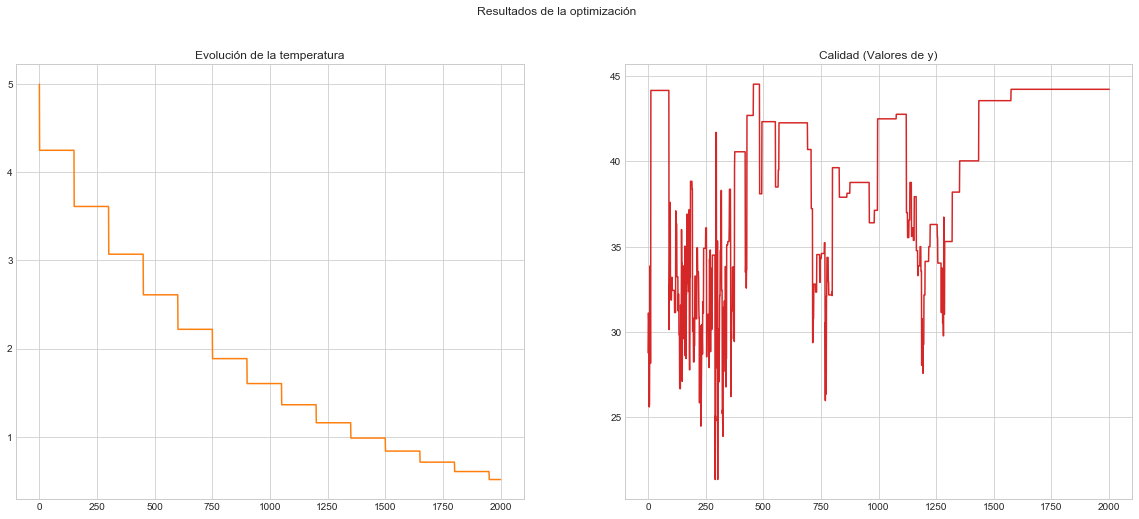

In [57]:
plot_results(valores_y, valores_t,x)

#### Análisis de la solución obtenida

In [58]:
p_bets_sa = [0.10,0.15,0.11,0.10,0.15,0.14,0.25]

In [59]:
LEAVE_WITH_MIN = 0 # Mínimo número de fichas con las que el jugador se retira
LEAVE_WITH_MAX = 150 # Máximo número de fichas con las que el jugador se retira
NUM_GAMES = 50 # Número máximo de partidas que puede jugar un jugador
INITIAL_CHIPS = 30 # Número de fichas iniciales con las que comienza a jugar
DAYS = 30 # Número de días que el jugador va a ir a jugara a la ruleta

In [60]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_sa)

Vamos a visualizar la matriz creada por medio de la libreria pandas y añadiendo un vector de filas y columnas que representan los estados del problema, es decir, las fichas que tiene el jugador en cada momento. 

In [61]:
df = pd.DataFrame(matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.847568,0.000000,0.048649,0.048649,0.000000,0.000000,0.017838,0.000000,0.000000,0.010811,0.000000,0.000000,0.012162,0.000000,0.000000,0.000000,0.0,0.0,0.007568,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006757,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.847568,0.000000,0.048649,0.048649,0.000000,0.000000,0.017838,0.000000,0.000000,0.010811,0.000000,0.000000,0.012162,0.000000,0.000000,0.0,0.0,0.000000,0.007568,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.006757,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.847568,0.000000,0.048649,0.048649,0.000000,0.000000,0.017838,0.000000,0.000000,0.010811,0.000000,0.000000,0.012162,0.000000,0.0,0.0,0.000000,0.000000,0.007568,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006757,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [62]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

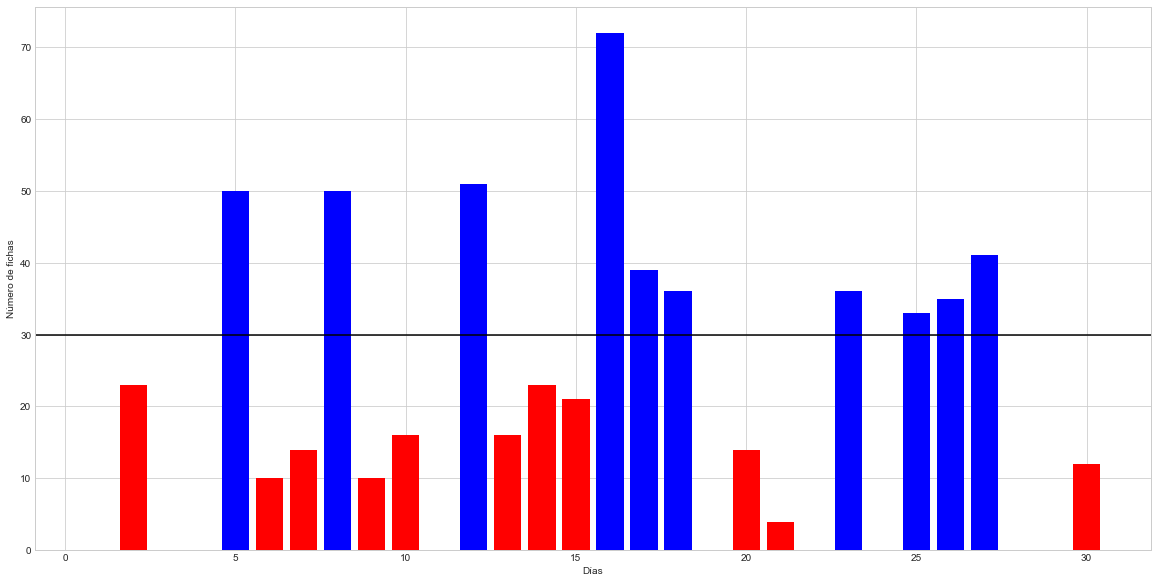

In [63]:
plot_bar_graph(df, INITIAL_CHIPS)

In [64]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 9
Porcentaje de noches que el jugador perdió todas las fichas: 30.0%
Número de noches que el jugador perdió fichas: 20
Porcentaje de noches que el jugador perdió fichas: 66.67%
Número de noches que el jugador salió igual del casino: 0
Porcentaje de noches que el jugador salió igual del casino: 0.0%
Número de noches que el jugador ganó fichas: 10
Porcentaje de noches que el jugador ganó fichas: 33.33%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 0
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 0.0%


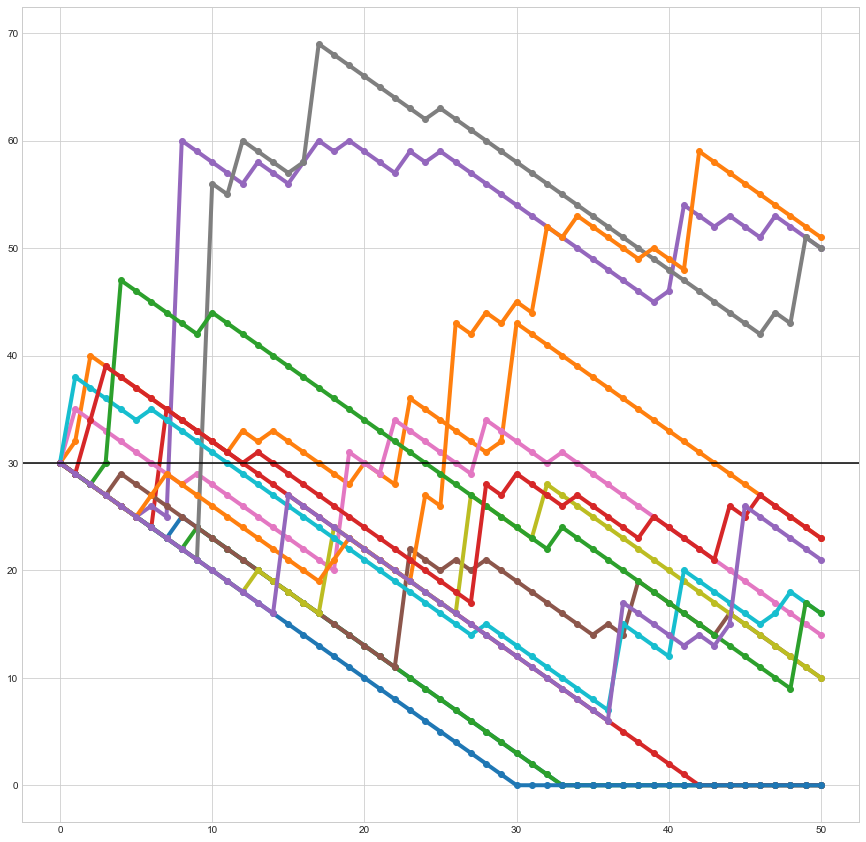

In [65]:
plot_chips_evolution(chips[:15])

Por último, vamos a mostra rle histograma de frecuencia de la cantidad de fichas con las que le jugador es capaz de salir del casino a lo largo de un mes. 

(0, 108.20342422101784)

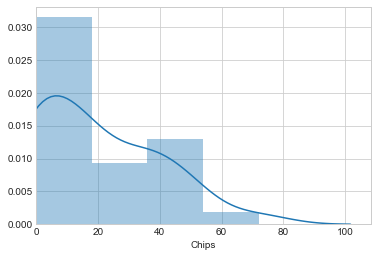

In [66]:
sns.distplot(df['Chips']);plt.xlim(0,None)

In [67]:
ruined = df[df['Chips'] == 0]
ruined

,Day,Chips,Games,Benefit,Improvement
0,1,0,33,-30,-1.0
2,3,0,33,-30,-1.0
3,4,0,42,-30,-1.0
10,11,0,30,-30,-1.0
18,19,0,32,-30,-1.0
21,22,0,37,-30,-1.0
23,24,0,39,-30,-1.0
27,28,0,39,-30,-1.0
28,29,0,35,-30,-1.0
